<a href="https://colab.research.google.com/github/Rishikesh-2006/NNs/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")


Skipping, found downloaded files in "./cat-and-dog" (use force=True to force download)


In [27]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms

In [28]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),])
data = datasets.ImageFolder("/content/cat-and-dog/training_set/training_set",transform=transform)


lat_dim = 100
channel = 3

In [29]:
#Architecture

class Dataset(Dataset):
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
  def __len__(self):
    return len(self.features)
  def __getitem__(self,i):
    return self.features[i],self.labels[i]


class GAN_Gen(nn.Module):
  def __init__(self):
    super().__init__()
    self.Gen = nn.Sequential(

          nn.ConvTranspose2d(lat_dim,512,4,stride=1,padding=0,bias=False),
          nn.BatchNorm2d(512),
          nn.ReLU(True),

          #size = (Batch_size,512,4,4)

          nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(True),

          #size = (Batch_size,256,8,8)

          nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),

          #size = (Batch_size,128,16,16)

          nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(True),

          #size = (Batch_size,64,32,32)

          nn.ConvTranspose2d(64,channel,4,stride=2,padding =1,bias=False),
          nn.Tanh()

          #size = (Batch_size,3,64,64)
      )
  def forward(self,x):
    return self.Gen(x)


class GAN_Dis(nn.Module):
  def __init__(self):
    super().__init__()
    self.Dis = nn.Sequential(
          nn.Conv2d(channel,64,4,2,padding = 1,bias=False),
          nn.LeakyReLU(0.2,inplace = True),

          #size 32,32

          nn.Conv2d(64,128,4,2,padding=1,bias = False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2,inplace = True),

          #size 16,16

          nn.Conv2d(128,256,4,2,padding=1,bias = False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2,inplace = True),

          #size 8,8

          nn.Conv2d(256,512,4,2,padding=1,bias = False),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2,inplace = True),

          #size 4,4

          nn.Conv2d(512,1,4,1,padding=0,bias = False),
          nn.Sigmoid()
      )
  def forward(self,x):
    return self.Dis(x).view(-1)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = DataLoader(data,batch_size=32,shuffle=True)

lr = 0.002
epochs = 50
batch_size = 32
criterion = nn.BCELoss()
Gen = GAN_Gen().to(device)
Gen_opt = optim.Adam(Gen.parameters(),lr = lr,betas=(0.5,0.999))

Dis = GAN_Dis().to(device)
Dis_opt = optim.Adam(Dis.parameters(),lr = lr,betas=(0.5,0.999))
print(device)


cuda


In [31]:
#Training
Gen.train()
Dis.train()
for epoch in range(epochs):
  DIS_LOSS = 0
  GEN_LOSS = 0

  for real_img ,_ in data:
    real_img = real_img.to(device)
    batch_size = real_img.size(0)

    fake_label = torch.zeros(batch_size,device=device)
    real_label = torch.ones(batch_size,device=device)

    noise = torch.randn(batch_size,lat_dim,1,1,device=device)
    fake_img = Gen(noise)

    #Discriminator training

    D_real = Dis(real_img)
    D_fake = Dis(fake_img.detach())

    loss1=criterion(D_real,real_label)
    loss2=criterion(D_fake,fake_label)
    loss_D = loss1 + loss2

    Dis_opt.zero_grad()
    loss_D.backward()
    Dis_opt.step()

    # Generator training

    Dis_fake = Dis(fake_img)

    loss_G = criterion(Dis_fake,real_label)
    Gen_opt.zero_grad()
    loss_G.backward()
    Gen_opt.step()

    DIS_LOSS += loss_D.item()
    GEN_LOSS += loss_G.item()
  print(f"epoch-{epoch+1}  Generator loss = {DIS_LOSS}  Discriminator loss = {GEN_LOSS}")






epoch-1  Generator loss = 382.28106336295605  Discriminator loss = 639.1804334819317
epoch-2  Generator loss = 335.7146147787571  Discriminator loss = 516.3651103377342
epoch-3  Generator loss = 304.8638169467449  Discriminator loss = 524.2846702337265
epoch-4  Generator loss = 281.8065369576216  Discriminator loss = 597.6532184481621
epoch-5  Generator loss = 290.95274317264557  Discriminator loss = 577.5295266509056
epoch-6  Generator loss = 292.1201334297657  Discriminator loss = 584.7283364534378
epoch-7  Generator loss = 283.65318566560745  Discriminator loss = 568.8859478533268
epoch-8  Generator loss = 302.5826122164726  Discriminator loss = 508.8801693916321
epoch-9  Generator loss = 300.7033247947693  Discriminator loss = 499.73803091049194
epoch-10  Generator loss = 291.0562428832054  Discriminator loss = 511.9584270119667
epoch-11  Generator loss = 275.5013647079468  Discriminator loss = 586.9829704761505
epoch-12  Generator loss = 270.61897373199463  Discriminator loss = 60

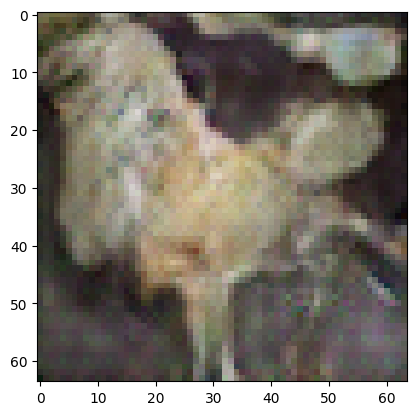

In [39]:
Gen.eval()
Dis.eval()
with torch.no_grad():
  noise = torch.randn(32,lat_dim,1,1,device=device)
  image = Gen(noise).detach().cpu().numpy()
  plt.imshow(image[1].transpose(1,2,0))
  plt.show()

